In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
batch_size = 128
epoch = 7
learning_rate = 0.01

# prepare dataset
dataset = datasets.MNIST(
    root='./mnist', train=True, transform=transforms.ToTensor(), download=True)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [55000, 5000])

test_dataset = datasets.MNIST(
    root='./mnist', train=False, transform=transforms.ToTensor())

# data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
class Learning():
    def __init__(self, epoch, model, criterion, optimizer, num_layer):
        self.epoch = epoch
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_layer = num_layer

    
    def train(self):
        epoch = self.epoch
        model = self.model
        criterion = self.criterion
        optimizer = self.optimizer
        
        train_loss_graph = []
        val_loss_graph = []
        train_acc_graph = []
        val_acc_graph = []
        
        writer = SummaryWriter(logdir='logs/pytorch')

        model.train()
        for e in range(epoch):
            # Training    
            train_loss = 0
            train_acc = 0

            val_loss = 0
            val_acc = 0
            train_total = 0
            print("[Epoch (%d)] -------------------------------" % (e + 1))
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = Variable(data), Variable(target)
                output = model(data)
                loss = criterion(output, target)

                # backward 전 optimizer 객체를 사용해 갱신할 변수에 대한 변화도를 0으로 만든다
                # backward를 호출할 때마다 변화도가 덮어쓰지 않고 누적되기 때문이다
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(output.data, 1) # [128, ]

                train_total += target.size(0)
                train_acc += (predicted == target).sum().item()
                train_loss += loss.item()

                if batch_idx % 100 == 0:
                    print('Train Epoch: %d, Loss: %.6f, Accuracy: %d' % (e + 1, loss.item(), 100 * train_acc / train_total))

            train_loss_graph.append(train_loss / train_total)
            train_acc_graph.append(train_acc / train_total)

            # Validation
            val_total = 0
            val_correct = 0
            for batch_idx, (data, target) in enumerate(val_loader):
                with torch.no_grad():
                    data, target = Variable(data), Variable(target)
                    output = model(data)
                    loss = criterion(output, target)
                    _, predicted = torch.max(output.data, 1)
                    val_total += target.size(0)
                    val_correct += (predicted == target).sum().item()

                    val_loss += loss.item()
                    acc = (predicted == target).sum().item()
                    val_acc += acc

                    if batch_idx % 10 == 0:
                        print('Validation Epoch: %d, Loss: %.6f, Accuracy: %d' % (e + 1, loss.item(), 100 * val_correct / val_total))

            val_loss_graph.append(val_loss / val_total)
            val_acc_graph.append(val_acc / val_total)
            
            writer.add_scalars(self.num_layer + 'loss', {'train': train_loss / train_total, 'val': val_loss / val_total}, e)
            writer.add_scalars(self.num_layer + 'accuracy', {'train': train_acc / train_total, 'val': val_acc / val_total}, e)
                                                      

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
                                                      
        writer.close()
        
        return {'train_loss_graph': train_loss_graph, 'val_loss_graph': val_loss_graph, 'train_acc_graph': train_acc_graph, 'val_acc_graph': val_acc_graph}

    def test(self):
        model = self.model
        criterion = self.criterion
        
        model.eval()
        test_loss = 0
        correct = 0
        acc = 0
        test_pred = []
        test_score= []
        test_data = []
        test_label = []
        for i, (data, target) in enumerate(test_loader):
            with torch.no_grad():
                data, target = Variable(data), Variable(target)
                output = model(data)
                loss = criterion(output, target).item()
                test_loss += loss

                _, pred = torch.max(output.data, 1)
                score = output.data.numpy()
                score = np.exp(score)
                score /= np.sum(score, axis=1).reshape(-1, 1)
                score = np.max(score, axis=1)

                test_pred.extend(pred)
                test_score.extend(score)
                test_data.extend(data.numpy())
                test_label.extend(target.numpy())

                correct += (pred == target).sum().item()
                acc += (pred == target).sum().item()

                test_loss /= len(test_loader.dataset)

        print('Test Average loss: %.4f, Accuracy: %.0f' % (test_loss, 100. * correct / len(test_loader.dataset)))
        return {'test_pred': test_pred, 'test_score': test_score, 'test_data': test_data, 'test_label': test_label}

In [4]:
class TwoLayerNet(nn.Module):
    def __init__(self):
        super(TwoLayerNet, self).__init__()
        
        # (28, 28, 1) -> (28, 28, 32) -> (14, 14, 8)
        self.layer_1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # (14, 14, 8) -> (14, 14, 16) -> (7, 7, 16)
        self.layer_2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # (7, 7, 16) -> (10, )
        self.fc = nn.Linear(7 * 7 * 16, 10)
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = out.view(out.size(0), -1) # flatten
        out = self.fc(out)
        
        return out

In [5]:
np.random.seed(0)

net = TwoLayerNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [6]:
learning = Learning(epoch, net, criterion, optimizer, num_layer="two_layer_")

stats = learning.train()

[Epoch (1)] -------------------------------
Train Epoch: 1, Loss: 2.305389, Accuracy: 9
Train Epoch: 1, Loss: 2.272565, Accuracy: 15
Train Epoch: 1, Loss: 2.177247, Accuracy: 20
Train Epoch: 1, Loss: 1.754215, Accuracy: 31
Train Epoch: 1, Loss: 0.706417, Accuracy: 42
Validation Epoch: 1, Loss: 0.670776, Accuracy: 84
Validation Epoch: 1, Loss: 0.673985, Accuracy: 81
Validation Epoch: 1, Loss: 0.686474, Accuracy: 81
Validation Epoch: 1, Loss: 0.748130, Accuracy: 82
[Epoch (2)] -------------------------------
Train Epoch: 2, Loss: 0.596417, Accuracy: 85
Train Epoch: 2, Loss: 0.381856, Accuracy: 84
Train Epoch: 2, Loss: 0.451082, Accuracy: 85
Train Epoch: 2, Loss: 0.304379, Accuracy: 86
Train Epoch: 2, Loss: 0.217331, Accuracy: 87
Validation Epoch: 2, Loss: 0.365173, Accuracy: 90
Validation Epoch: 2, Loss: 0.274290, Accuracy: 90
Validation Epoch: 2, Loss: 0.389403, Accuracy: 89
Validation Epoch: 2, Loss: 0.440929, Accuracy: 90
[Epoch (3)] -------------------------------
Train Epoch: 3, Los

In [7]:
# test
tests = learning.test()

Test Average loss: 0.0000, Accuracy: 96


In [8]:
test_pred = np.array(tests['test_pred'])
test_score = np.array(tests['test_score'])
test_data = np.array(tests['test_data'])
test_data = test_data.reshape(-1, 784)
test_label = np.array(tests['test_label'])

In [9]:
scores_dict = defaultdict(list)
for i in range(len(test_pred)):
    scores_dict[test_pred[i]].append((test_score[i], i))

# print(scores_dict)

top_3_dict = defaultdict(list)
for key in scores_dict.keys():
    values = scores_dict[key]
    values.sort(key=lambda x: x[0], reverse=True)
    top_3_dict[key].extend(values[:3])

In [10]:
# tensorboard - top 3 images

writer = SummaryWriter(logdir='logs/pytorch')

for i in range(10):
    top_3_values = top_3_dict[i]
    for j in range(3):
        best_img = np.reshape(test_data[top_3_values[j][1]], (1, 28, 28))
        title = 'two_layer_class_' + str(i) + "_" + str(j) + '/prob_' + str(round(top_3_values[j][0], 5))
        writer.add_image(title, best_img)

writer.close()

Text(69.0, 0.5, 'True label')

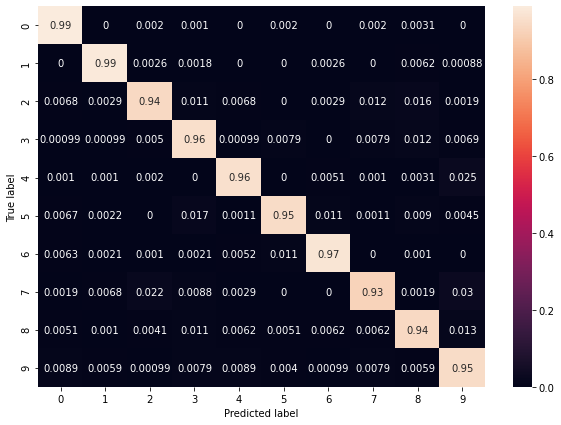

In [11]:
# confusion matrix
confusion = confusion_matrix(test_label, test_pred)
confusion = confusion.astype(np.float) / confusion.astype(np.float).sum(axis=1, keepdims=True)

df = pd.DataFrame(confusion, range(10), range(10))
plt.figure(figsize = (10,7))
sn.heatmap(df, annot=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")

In [12]:
class ThreeLayerNet(nn.Module):
    def __init__(self):
        super(ThreeLayerNet, self).__init__()
        
        # (28, 28, 1) -> (28, 28, 8) -> (14, 14, 8)
        self.layer_1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # (14, 14, 8) -> (14, 14, 10) -> (7, 7, 10)
        self.layer_2 = nn.Sequential(
            nn.Conv2d(8, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # (7, 7, 10) -> (7, 7, 16) -> (4, 4, 16)
        self.layer_3 = nn.Sequential(
            nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        
        # (4, 4, 16) -> (10, )
        self.fc = nn.Linear(4 * 4 * 16, 10)
    
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [13]:
np.random.seed(1)

net_2 = ThreeLayerNet()

criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(net_2.parameters(), lr=learning_rate)

In [14]:
learning_2 = Learning(epoch, net_2, criterion_2, optimizer_2, num_layer="three_layer_")

stats_2 = learning_2.train()

[Epoch (1)] -------------------------------
Train Epoch: 1, Loss: 2.299513, Accuracy: 10
Train Epoch: 1, Loss: 2.299705, Accuracy: 9
Train Epoch: 1, Loss: 2.295785, Accuracy: 10
Train Epoch: 1, Loss: 2.294316, Accuracy: 10
Train Epoch: 1, Loss: 2.300344, Accuracy: 12
Validation Epoch: 1, Loss: 2.297500, Accuracy: 10
Validation Epoch: 1, Loss: 2.299293, Accuracy: 9
Validation Epoch: 1, Loss: 2.294532, Accuracy: 10
Validation Epoch: 1, Loss: 2.294288, Accuracy: 11
[Epoch (2)] -------------------------------
Train Epoch: 2, Loss: 2.297412, Accuracy: 7
Train Epoch: 2, Loss: 2.294741, Accuracy: 11
Train Epoch: 2, Loss: 2.288400, Accuracy: 11
Train Epoch: 2, Loss: 2.287235, Accuracy: 12
Train Epoch: 2, Loss: 2.291304, Accuracy: 12
Validation Epoch: 2, Loss: 2.285122, Accuracy: 13
Validation Epoch: 2, Loss: 2.288296, Accuracy: 10
Validation Epoch: 2, Loss: 2.280545, Accuracy: 11
Validation Epoch: 2, Loss: 2.284249, Accuracy: 11
[Epoch (3)] -------------------------------
Train Epoch: 3, Loss:

In [15]:
# test
tests_2 = learning_2.test()

Test Average loss: 0.0000, Accuracy: 94


In [16]:
test_pred = np.array(tests_2['test_pred'])
test_score = np.array(tests_2['test_score'])
test_data = np.array(tests_2['test_data'])
test_data = test_data.reshape(-1, 784)
test_label = np.array(tests_2['test_label'])

In [17]:
scores_dict = defaultdict(list)
for i in range(len(test_pred)):
    scores_dict[test_pred[i]].append((test_score[i], i))

# print(scores_dict)

top_3_dict = defaultdict(list)
for key in scores_dict.keys():
    values = scores_dict[key]
    values.sort(key=lambda x: x[0], reverse=True)
    top_3_dict[key].extend(values[:3])

In [18]:
# tensorboard - top 3 images

writer = SummaryWriter(logdir='logs/pytorch')

for i in range(10):
    top_3_values = top_3_dict[i]
    for j in range(3):
        best_img = np.reshape(test_data[top_3_values[j][1]], (1, 28, 28))
        title = 'three_layer_class_' + str(i) + "_" + str(j) + '/prob_' + str(round(top_3_values[j][0], 5))
        writer.add_image(title, best_img)

writer.close()

Text(69.0, 0.5, 'True label')

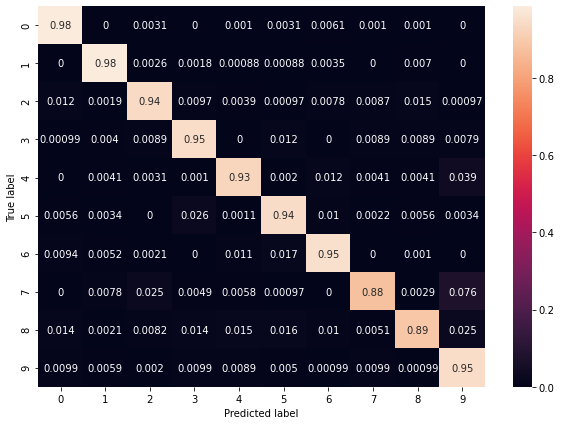

In [19]:
# confusion matrix
confusion = confusion_matrix(test_label, test_pred)
confusion = confusion.astype(np.float) / confusion.astype(np.float).sum(axis=1, keepdims=True)

df = pd.DataFrame(confusion, range(10), range(10))
plt.figure(figsize = (10,7))
sn.heatmap(df, annot=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")